# Installs & Imports

In [1]:
!pip install -q rpy2

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
import contextlib
import io
import os
from IPython.display import Image, display, HTML
from rpy2.robjects.packages import importr, PackageNotInstalledError
from rpy2.robjects.vectors import StrVector
from rpy2.robjects import r, pandas2ri, DataFrame
import rpy2.robjects as ro
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import FloatVector, StrVector
import rpy2.robjects.lib.grdevices as grdevices
import rpy2.ipython.html

# Enable R printing
rpy2.ipython.html.init_printing()

# Enable automatic DataFrame conversion
pandas2ri.activate()

In [3]:
# Function to install and import R packages
def manage_r_packages(packages):
    """
    Installs missing R packages and imports them into Python.

    Parameters:
    packages (list): List of R package names to check, install, and import.

    Returns:
    dict: Dictionary of imported R packages.
    """
    missing_packages = []
    installed_packages = {}

    # Check which packages are already installed and install missing ones
    for package_name in packages:
        try:
            installed_packages[package_name] = importr(package_name)
            print(f"{package_name} is already installed and imported.")
        except PackageNotInstalledError:
            missing_packages.append(package_name)

    # If there are missing packages, install them
    if missing_packages:
        print(f"Installing missing packages: {missing_packages}")
        utils = importr('utils')
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            with contextlib.redirect_stdout(None):
                utils.install_packages(StrVector(missing_packages), quiet=True)

        # Import newly installed packages
        for package_name in missing_packages:
            try:
                installed_packages[package_name] = importr(package_name)
                print(f"Successfully installed and imported {package_name}.")
            except Exception as e:
                print(f"Failed to import {package_name} after installation: {str(e)}")
    else:
        print("All required packages are already installed and imported.")

    return installed_packages

In [4]:
# List of required R packages
required_packages = ['forecast', 'lazyeval', 'ggplot2', 'bsts', 'tseries', 'Metrics']

# Install and import required R packages
importr('base')
importr('utils')
r_packages = manage_r_packages(required_packages)

ggplot2 is already installed and imported.
Installing missing packages: ['forecast', 'lazyeval', 'bsts', 'tseries', 'Metrics']


In [5]:
# Function to make rpy2 usage easier
def run_r_script(r_code, dataframe=None):
    """
    Executes the provided R code string, optionally passing a Pandas DataFrame into the R environment.
    Returns the list of R objects.

    Parameters:
    r_code (str): The R code to be executed in string form.
    dataframe (pd.DataFrame, optional): The user's input DataFrame to be passed to R. Default is None.

    Returns:
    list: The list of R objects returned by the R code.
    """
    # If a DataFrame is provided, convert it to an R DataFrame and pass to the global environment
    if dataframe is not None:
        r_df = ro.DataFrame(dataframe)
        ro.globalenv['input_df'] = r_df

    # Run the provided R script
    results = r(r_code)

    return results

In [6]:
# Ensure the output directory exists
output_dir = "/content/output_plots"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Load the Data

Python Data:


,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390




DataFrame returned from R:


,Month,Passengers
1,1949-01-01,112
2,1949-02-01,118
3,1949-03-01,132
4,1949-04-01,129
5,1949-05-01,121
...,...,...
140,1960-08-01,606
141,1960-09-01,508
142,1960-10-01,461
143,1960-11-01,390


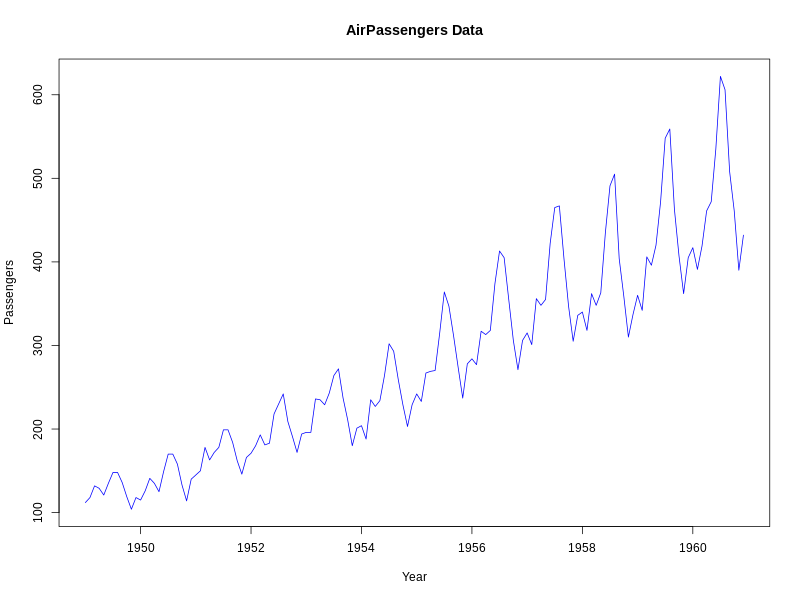

In [7]:
# Load the airline passengers dataset
data_url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
data = pd.read_csv(data_url, parse_dates=['Month'])

# Ensure the date displays with the first of the month
data['Month'] = data['Month'].dt.to_period('M').dt.to_timestamp()

# Python data
print("Python Data:")
display(data)
print("\n")

# R script
r_code = """
# Load necessary libraries
library(ggplot2)

# Create time series data from input DataFrame
airline_ts <- ts(input_df$Passengers, start = c(1949, 1), frequency = 12)

# Create dataframe with the first day of the month
data_r <- data.frame(Month = as.character(input_df$Month), Passengers = input_df$Passengers)

# Save the plot using base R
png('/content/output_plots/air_passengers_plot.png', width=800, height=600)
plot(airline_ts, main='AirPassengers Data', ylab='Passengers', xlab='Year', col='blue')
dev.off()

# Return list of objects
list(
    data_r = data_r
)
"""

# Run the R script and pass the DataFrame
results = run_r_script(r_code, dataframe=data)

# Display the DataFrame returned from R
print("DataFrame returned from R:")
display(results[0])

# Display the saved PNG plot in the notebook
airpassengers_plot = os.path.join(output_dir, "air_passengers_plot.png")
display(Image(filename=airpassengers_plot))

DataFrame returned from R:


,Passengers
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
...,...
1960-08-01,606.0
1960-09-01,508.0
1960-10-01,461.0
1960-11-01,390.0


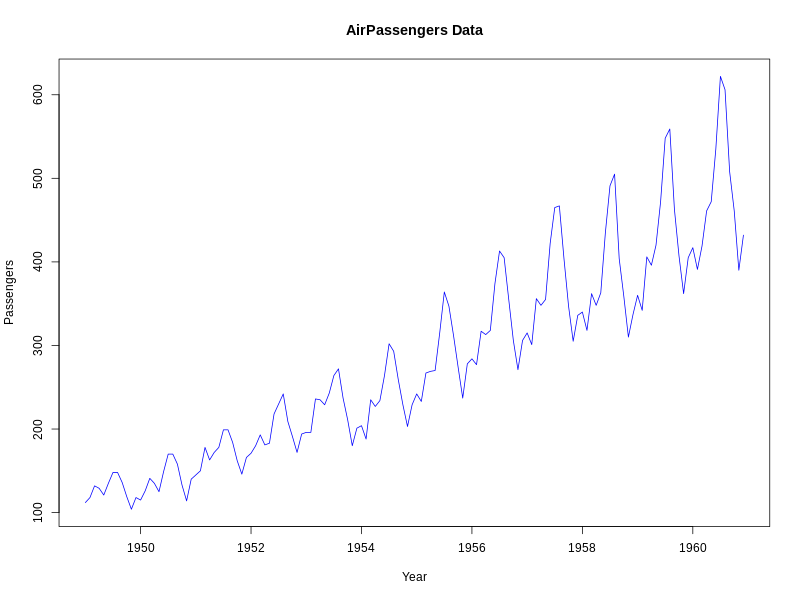

In [8]:
# R script
r_code = """
# Load necessary libraries
library(ggplot2)

# Load AirPassengers dataset
airline_ts <- AirPassengers

# Create dataframe with Month as POSIXct and assign to rownames
df <- data.frame(
  Month = as.POSIXct(as.Date(time(airline_ts), format = "%Y-%m-%d")),  # Convert to POSIXct
  Passengers = as.numeric(airline_ts)  # Extract passenger numbers
)

# Set rownames to be the datetime values (as characters)
rownames(df) <- as.character(df$Month)

# Drop the Month column to simulate using it as an index
df <- df[, "Passengers", drop = FALSE]  # Only keep the Passengers column

# Save the plot as a PNG file
png('/content/output_plots/air_passengers_plot.png', width=800, height=600)

# Plot time series with ggplot2
ggplot(df, aes(x = date, y = passengers)) +
  geom_line(color = "blue") +
  labs(title = "AirPassengers Time Series", x = "Date", y = "Passengers") +
  theme_minimal()

# Close the PNG device
dev.off()

# Return the dataframe created
list(df = df)
"""

# Run the R script
results = run_r_script(r_code)

# Extract the DataFrame returned from R
df_from_r = results[0]

# Display the DataFrame in Python
print("DataFrame returned from R:")
display(df_from_r)

# Display the saved PNG plot in the notebook
airpassengers_plot = os.path.join(output_dir, "air_passengers_plot.png")
display(Image(filename=airpassengers_plot))

# Prepare the Data

In [9]:
# R script
r_code = """
# Train-test split (80-20)
train_size <- floor(0.8 * nrow(input_df))
train_data <- input_df[1:train_size, ]
test_data <- input_df[(train_size + 1):nrow(input_df), ]

# Convert to time series
y_train <- ts(train_data$Passengers, frequency = 12, start = c(1949, 1))
y_test <- ts(test_data$Passengers, frequency = 12, start = c(1958, 1))

# Create dataframes
train_data <- data.frame(date = as.character(train_data$Month), passengers = train_data$Passengers)
test_data <- data.frame(date = as.character(test_data$Month), passengers = test_data$Passengers)
y_train <- as.numeric(y_train)
y_test <- as.numeric(y_test)

# Return train and test sets
list(
    train_data = train_data,
    test_data = test_data,
    y_train = y_train,
    y_test = y_test
)
"""

# Run the R script
results = run_r_script(r_code, dataframe=data)

# Extract the results from R
train_data = results[0]
test_data = results[1]
y_train = results[2]
y_test = results[3]

# Display the train and test DataFrames in Python
print("Train Data:")
display(train_data)

print("\nTest Data:")
display(test_data)

Train Data:


,date,passengers
1,1949-01-01,112
2,1949-02-01,118
3,1949-03-01,132
4,1949-04-01,129
5,1949-05-01,121
...,...,...
111,1958-03-01,362
112,1958-04-01,348
113,1958-05-01,363
114,1958-06-01,435



Test Data:


,date,passengers
1,1958-08-01,505
2,1958-09-01,404
3,1958-10-01,359
4,1958-11-01,310
5,1958-12-01,337
6,1959-01-01,360
7,1959-02-01,342
8,1959-03-01,406
9,1959-04-01,396
10,1959-05-01,420


# Run the Model

In [10]:
# R script: State-space model specification
r_code_state_spec = """
# Load necessary libraries
library(bsts)

# Calculate the standard deviation of y_train for components
sdy <- sd(y_train)

# Specify a simple state-space component: local level only
state_spec <- AddLocalLevel(list(), y_train)

# Print the state-space model structure
print(state_spec)

# Return the entire state-space model structure
list(state_spec = state_spec)
"""

# Run the R script
results_state_spec = run_r_script(r_code_state_spec)

# Extract the state-space model specification
state_spec = results_state_spec[0]

[[1]]
$name
[1] "trend"

$sigma.prior
$prior.guess
[1] 0.9134779

$prior.df
[1] 0.01

$initial.value
[1] 0.9134779

$fixed
[1] FALSE

$upper.limit
[1] 91.34779

attr(,"class")
[1] "SdPrior"         "DiffDoubleModel" "DoubleModel"     "Prior"          

$initial.state.prior
$mu
[1] 112

$sigma
[1] 91.34779

$initial.value
[1] 112

$fixed
[1] FALSE

attr(,"class")
[1] "NormalPrior"     "DiffDoubleModel" "DoubleModel"     "Prior"          

$size
[1] 1

attr(,"class")
[1] "LocalLevel" "StateModel"



In [11]:
# Define the R script for running the BSTS model
r_code_bsts_model = """
# Load necessary libraries
library(bsts)

# Set seed for reproducibility
set.seed(123)

# Fit BSTS model with 2000 MCMC iterations
bsts_model <- bsts(y_train, state.specification = state_spec, niter = 2000)

# Print model summary directly in R
print(summary(bsts_model))

# Return the model object
list(bsts_model = bsts_model)
"""

# Run the R script
results_bsts_model = run_r_script(r_code_bsts_model)

# Extract the BSTS model
bsts_model = results_bsts_model[0]

=-=-=-=-= Iteration 0 Thu Sep 12 04:54:59 2024 =-=-=-=-=
=-=-=-=-= Iteration 200 Thu Sep 12 04:54:59 2024 =-=-=-=-=
=-=-=-=-= Iteration 400 Thu Sep 12 04:54:59 2024 =-=-=-=-=
=-=-=-=-= Iteration 600 Thu Sep 12 04:54:59 2024 =-=-=-=-=
=-=-=-=-= Iteration 800 Thu Sep 12 04:54:59 2024 =-=-=-=-=
=-=-=-=-= Iteration 1000 Thu Sep 12 04:54:59 2024 =-=-=-=-=
=-=-=-=-= Iteration 1200 Thu Sep 12 04:54:59 2024 =-=-=-=-=
=-=-=-=-= Iteration 1400 Thu Sep 12 04:54:59 2024 =-=-=-=-=
=-=-=-=-= Iteration 1600 Thu Sep 12 04:54:59 2024 =-=-=-=-=
=-=-=-=-= Iteration 1800 Thu Sep 12 04:55:00 2024 =-=-=-=-=
$residual.sd
[1] 5.786689

$prediction.sd
[1] 27.06265

$rsquare
[1] 0.995987

$relative.gof
[1] -0.04310831



In [12]:
# R script: Adding Seasonal Component
r_code_state_spec = """
# Load necessary libraries
library(bsts)

# Calculate the standard deviation of y_train
sdy <- sd(y_train)

# Specify local level and seasonal components
state_spec <- AddLocalLevel(list(), y_train) %>%
              AddSeasonal(nseasons = 12, sdy = sdy)

# Print the state-space model structure
print(state_spec)

# Return the entire state-space model structure
list(state_spec = state_spec)
"""

# Run the R script
results_state_spec = run_r_script(r_code_state_spec)

# Extract the state-space model specification
state_spec = results_state_spec[0]

[[1]]
$name
[1] "trend"

$sigma.prior
$prior.guess
[1] 0.9134779

$prior.df
[1] 0.01

$initial.value
[1] 0.9134779

$fixed
[1] FALSE

$upper.limit
[1] 91.34779

attr(,"class")
[1] "SdPrior"         "DiffDoubleModel" "DoubleModel"     "Prior"          

$initial.state.prior
$mu
[1] 112

$sigma
[1] 91.34779

$initial.value
[1] 112

$fixed
[1] FALSE

attr(,"class")
[1] "NormalPrior"     "DiffDoubleModel" "DoubleModel"     "Prior"          

$size
[1] 1

attr(,"class")
[1] "LocalLevel" "StateModel"

[[2]]
$name
[1] "seasonal.12.1"

$nseasons
[1] 12

$season.duration
[1] 1

$sigma.prior
$prior.guess
[1] 0.9134779

$prior.df
[1] 0.01

$initial.value
[1] 0.9134779

$fixed
[1] FALSE

$upper.limit
[1] 91.34779

attr(,"class")
[1] "SdPrior"         "DiffDoubleModel" "DoubleModel"     "Prior"          

$initial.state.prior
$mu
[1] 0

$sigma
[1] 91.34779

$initial.value
[1] 0

$fixed
[1] FALSE

attr(,"class")
[1] "NormalPrior"     "DiffDoubleModel" "DoubleModel"     "Prior"          

$size
[1] 1

In [13]:
# Define the R script for running the BSTS model
r_code_bsts_model = """
# Load necessary libraries
library(bsts)

# Set seed for reproducibility
set.seed(123)

# Fit BSTS model with 2000 MCMC iterations
bsts_model <- bsts(y_train, state.specification = state_spec, niter = 2000)

# Print model summary directly in R
print(summary(bsts_model))

# Return the model object
list(bsts_model = bsts_model)
"""

# Run the R script
results_bsts_model = run_r_script(r_code_bsts_model)

# Extract the BSTS model
bsts_model = results_bsts_model[0]

=-=-=-=-= Iteration 0 Thu Sep 12 04:55:00 2024 =-=-=-=-=
=-=-=-=-= Iteration 200 Thu Sep 12 04:55:00 2024 =-=-=-=-=
=-=-=-=-= Iteration 400 Thu Sep 12 04:55:00 2024 =-=-=-=-=
=-=-=-=-= Iteration 600 Thu Sep 12 04:55:01 2024 =-=-=-=-=
=-=-=-=-= Iteration 800 Thu Sep 12 04:55:01 2024 =-=-=-=-=
=-=-=-=-= Iteration 1000 Thu Sep 12 04:55:01 2024 =-=-=-=-=
=-=-=-=-= Iteration 1200 Thu Sep 12 04:55:01 2024 =-=-=-=-=
=-=-=-=-= Iteration 1400 Thu Sep 12 04:55:02 2024 =-=-=-=-=
=-=-=-=-= Iteration 1600 Thu Sep 12 04:55:02 2024 =-=-=-=-=
=-=-=-=-= Iteration 1800 Thu Sep 12 04:55:02 2024 =-=-=-=-=
$residual.sd
[1] 3.854611

$prediction.sd
[1] 14.04091

$rsquare
[1] 0.9982194

$relative.gof
[1] 0.7023121



# Evaluate the Model

[1] "Diagnostics plots created successfully"



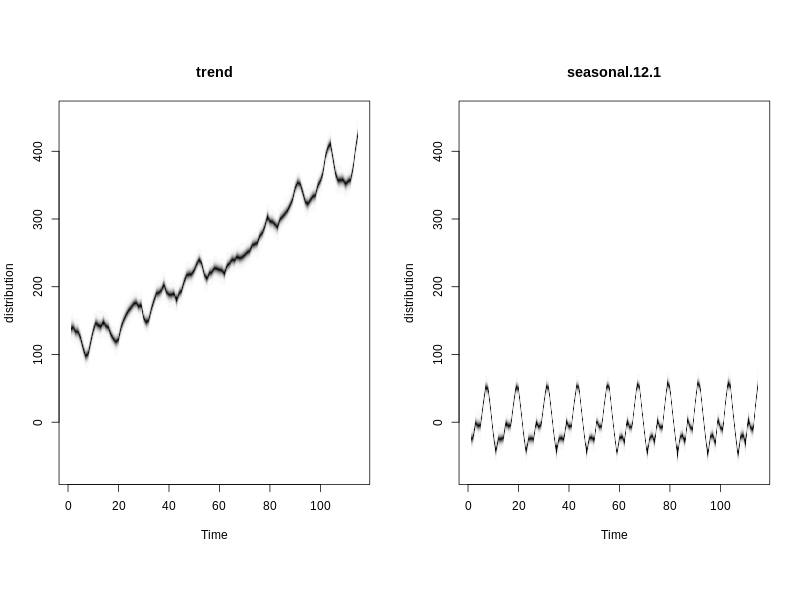

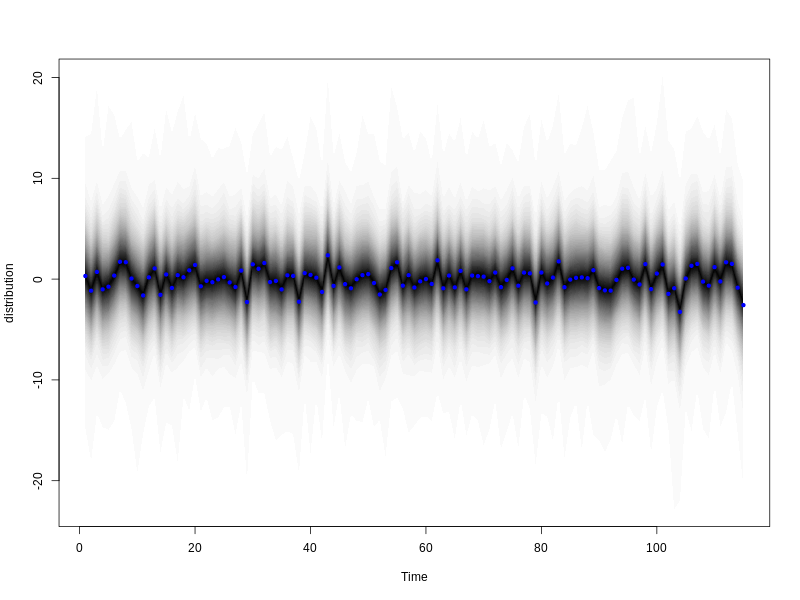

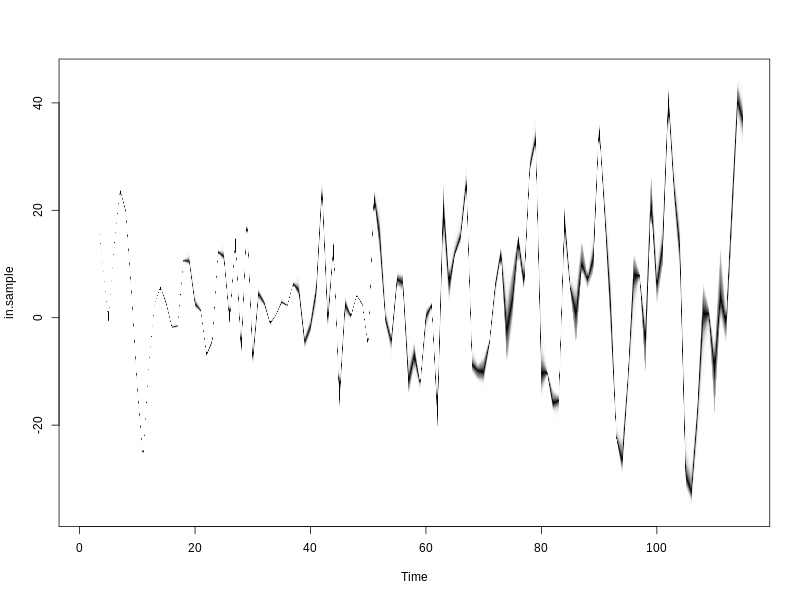

In [14]:
# R script for plotting diagnostics and checking model components
r_code_diagnostics = """
# Load necessary libraries
library(bsts)

# Plot model components
png('/content/output_plots/bsts_components.png', width=800, height=600)
plot(bsts_model, "components")
dev.off()

# Plot model residuals
png('/content/output_plots/bsts_residuals.png', width=800, height=600)
plot(bsts_model, "residuals")
dev.off()

# Plot prediction errors
png('/content/output_plots/bsts_prediction_errors.png', width=800, height=600)
plot(bsts_model, "prediction.errors")
dev.off()

# Return a success message
list(message = "Diagnostics plots created successfully")
"""

# Run the R script for diagnostics
results_diagnostics = run_r_script(r_code_diagnostics)

# Extract the success message
success_message = results_diagnostics[0]

# Print the success message
print(success_message)

# Display the saved plots in the notebook
bsts_components_plot = os.path.join(output_dir, "bsts_components.png")
bsts_residuals_plot = os.path.join(output_dir, "bsts_residuals.png")
bsts_prediction_errors_plot = os.path.join(output_dir, "bsts_prediction_errors.png")

display(Image(filename=bsts_components_plot))
display(Image(filename=bsts_residuals_plot))
display(Image(filename=bsts_prediction_errors_plot))

[1] "In-sample fit and ACF plots created successfully"



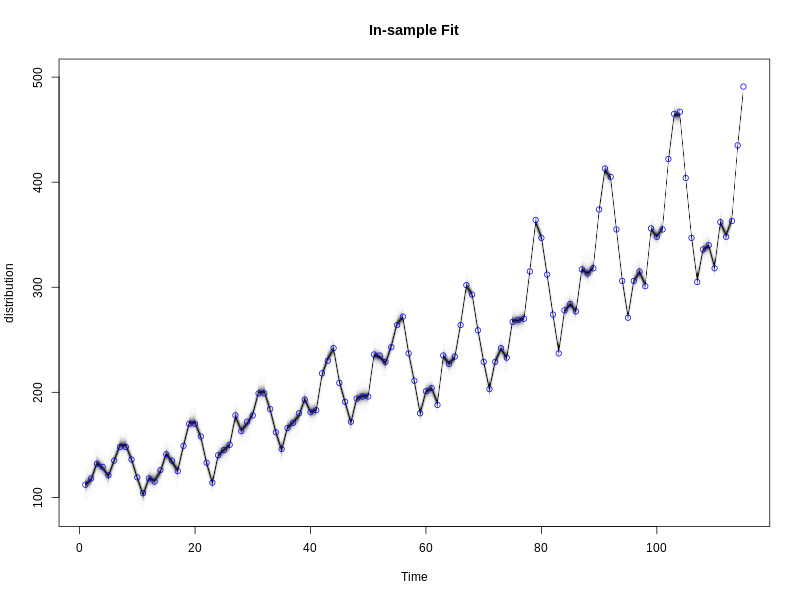

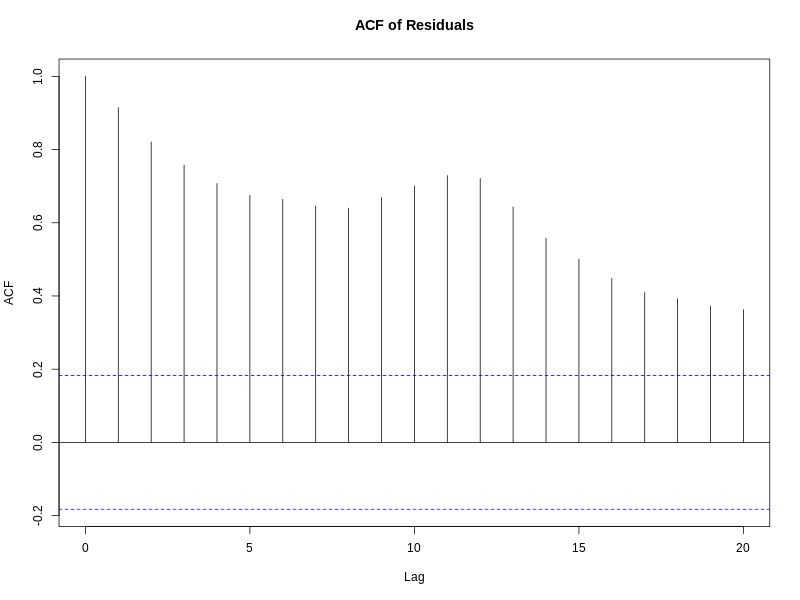

In [15]:
# R script for in-sample predictions and residuals ACF
r_code_in_sample_diagnostics = """
# Load necessary libraries
library(bsts)

# In-sample fit plot
png('/content/output_plots/bsts_in_sample_fit.png', width=800, height=600)
plot(bsts_model, main = "In-sample Fit")
dev.off()

# Residuals and ACF plot
residuals_train <- y_train - predict(bsts_model)$mean
png('/content/output_plots/bsts_acf_residuals.png', width=800, height=600)
acf(residuals_train, main = "ACF of Residuals")
dev.off()

# Return a success message
list(message = "In-sample fit and ACF plots created successfully")
"""

# Run the R script for in-sample diagnostics
results_in_sample_diagnostics = run_r_script(r_code_in_sample_diagnostics)

# Extract the success message
success_message = results_in_sample_diagnostics[0]

# Print the success message
print(success_message)

# Display the saved plots in the notebook
bsts_in_sample_fit_plot = os.path.join(output_dir, "bsts_in_sample_fit.png")
bsts_acf_residuals_plot = os.path.join(output_dir, "bsts_acf_residuals.png")

# Display the plots
display(Image(filename=bsts_in_sample_fit_plot))
display(Image(filename=bsts_acf_residuals_plot))

Length of y_test: 29 
Number of rows in test_data: 29 
Length of y_test_aligned: 29 
Number of rows in test_data_aligned: 29 
Length of predictions$mean: 29 
Dimensions of predictions$interval: 2 29 
Length of lower_bound: 29 
Length of upper_bound: 29 
Saving plot to: /content/output_plots/bsts_forecast_plot_with_legend.png 
Current working directory: /content 
Contents of output directory:
[1] "air_passengers_plot.png"            "bsts_acf_residuals.png"            
[3] "bsts_components.png"                "bsts_forecast_plot_with_legend.png"
[5] "bsts_in_sample_fit.png"             "bsts_prediction_errors.png"        
[7] "bsts_residuals.png"                
[1] "Forecast plot with legend created successfully"

Files in output directory: ['bsts_in_sample_fit.png', 'bsts_residuals.png', 'bsts_prediction_errors.png', 'bsts_forecast_plot_with_legend.png', 'bsts_components.png', 'air_passengers_plot.png', 'bsts_acf_residuals.png']


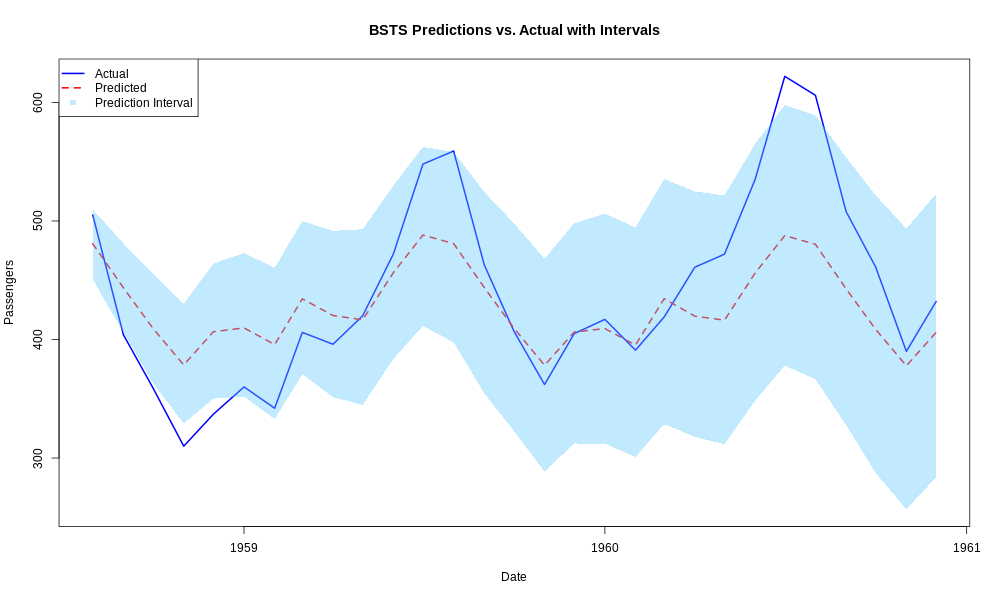

In [16]:
# R script for forecasting with intervals
r_code_forecast_plot = """
# Load necessary libraries
library(ggplot2)

# Ensure y_test and test_data are aligned and have matching lengths
forecast_horizon <- length(y_test)
test_data_length <- nrow(test_data)

# Print lengths to debug
cat('Length of y_test:', forecast_horizon, '\\n')
cat('Number of rows in test_data:', test_data_length, '\\n')

# Adjust forecast_horizon if needed
forecast_horizon <- min(forecast_horizon, test_data_length)

# Truncate y_test and test_data to the forecast horizon length
y_test_aligned <- as.numeric(y_test[1:forecast_horizon])
test_data_aligned <- test_data[1:forecast_horizon, ]

# Ensure lengths match after alignment
cat('Length of y_test_aligned:', length(y_test_aligned), '\\n')
cat('Number of rows in test_data_aligned:', nrow(test_data_aligned), '\\n')

# Forecast (with intervals) for the test set horizon
predictions <- predict(bsts_model, horizon = forecast_horizon)

# Print the structure and lengths of the prediction components
cat('Length of predictions$mean:', length(predictions$mean), '\\n')
cat('Dimensions of predictions$interval:', dim(predictions$interval), '\\n')

# Extraction of intervals
lower_bound <- as.numeric(predictions$interval[1, 1:forecast_horizon])  # First row (2.5%)
upper_bound <- as.numeric(predictions$interval[2, 1:forecast_horizon])  # Second row (97.5%)

# Check if the dimensions match
cat('Length of lower_bound:', length(lower_bound), '\\n')
cat('Length of upper_bound:', length(upper_bound), '\\n')

# Extract forecast mean, lower/upper bounds with corresponding date column
forecast_df <- data.frame(
  date = as.Date(test_data_aligned$date),  # Use the actual dates from the test set
  actual = y_test_aligned,
  predicted = predictions$mean[1:forecast_horizon],
  lower_bound = lower_bound,
  upper_bound = upper_bound
)

# Ensure the output directory exists
dir.create('/content/output_plots', showWarnings = FALSE)

# Save the plot as a PNG file and print file path
output_file <- '/content/output_plots/bsts_forecast_plot_with_legend.png'
cat('Saving plot to:', output_file, '\\n')

# Base R plotting with adjusted color and transparency for the interval band
png(output_file, width=1000, height=600)

# Define plot limits to prevent clipping
ylim_vals <- range(forecast_df$lower_bound, forecast_df$upper_bound, forecast_df$actual)

# Plot actual vs. predicted and intervals
plot(forecast_df$date, forecast_df$actual, type = "l", col = "blue", lwd = 2,
     ylim = ylim_vals, xlab = "Date", ylab = "Passengers",
     main = "BSTS Predictions vs. Actual with Intervals")

# Add predicted line
lines(forecast_df$date, forecast_df$predicted, col = "red", lwd = 2, lty = 2)

# Add the confidence interval as a shaded area
polygon(c(forecast_df$date, rev(forecast_df$date)),
        c(forecast_df$lower_bound, rev(forecast_df$upper_bound)),
        col = rgb(0.4, 0.8, 1, alpha = 0.4), border = NA)

# Add a legend to the top left
legend("topleft", legend = c("Actual", "Predicted", "Prediction Interval"),
       col = c("blue", "red", rgb(0.4, 0.8, 1, alpha = 0.4)),
       lty = c(1, 2, NA), lwd = c(2, 2, NA), pch = c(NA, NA, 15), pt.bg = rgb(0.4, 0.8, 1, alpha = 0.4))

dev.off()

# Print current working directory and contents for debugging
cat('Current working directory:', getwd(), '\\n')
cat('Contents of output directory:\\n')
print(list.files('/content/output_plots'))

# Return a success message
list(message = 'Forecast plot with legend created successfully')
"""

# Run the R script for forecasting and plotting
results_forecast_plot = run_r_script(r_code_forecast_plot)

# Extract the success message
success_message = results_forecast_plot[0]

# Print the success message
print(success_message)

# Check the contents of the output directory
output_files = os.listdir(output_dir)
print("Files in output directory:", output_files)

# Display the saved forecast plot in the notebook if it exists
bsts_forecast_plot = os.path.join(output_dir, "bsts_forecast_plot_with_legend.png")

if os.path.exists(bsts_forecast_plot):
    display(Image(filename=bsts_forecast_plot))
else:
    print("Plot file not found. Debug the output path and ensure the plot was saved correctly.")

In [17]:
# R script for calculating forecast accuracy metrics: MSE, RMSE, MAPE, sMAPE
r_code_forecast_accuracy = """
# Load necessary libraries
library(Metrics)

# Ensure y_test and predictions$mean are aligned
forecast_horizon <- length(y_test)
predicted_mean <- predictions$mean[1:forecast_horizon]

# Calculate accuracy metrics
mse_val <- mse(y_test, predicted_mean)
rmse_val <- rmse(y_test, predicted_mean)
mape_val <- mape(y_test, predicted_mean)
smape_val <- sum(2 * abs(predicted_mean - y_test) / (abs(predicted_mean) + abs(y_test))) * 100 / forecast_horizon

# Print the forecast accuracy metrics
cat("Forecast Accuracy Metrics:\\n")
cat("MSE: ", mse_val, "\\n")
cat("RMSE: ", rmse_val, "\\n")
cat("MAPE: ", mape_val, "\\n")
cat("sMAPE: ", smape_val, "\\n")

# Return the accuracy metrics as a list
list(mse = mse_val, rmse = rmse_val, mape = mape_val, smape = smape_val)
"""

# Run the R script for forecast accuracy
results_forecast_accuracy = run_r_script(r_code_forecast_accuracy)

# Extract the forecast accuracy metrics
mse_val = results_forecast_accuracy[0]
rmse_val = results_forecast_accuracy[1]
mape_val = results_forecast_accuracy[2]
smape_val = results_forecast_accuracy[3]

Forecast Accuracy Metrics:
MSE:  2916.474 
RMSE:  54.00439 
MAPE:  0.09326585 
sMAPE:  9.429273 


Shapiro-Wilk Test for Normality:
W statistic:  0.9658316 
p-value:  0.4529301 
Shapiro-Wilk Test for Normality:
W statistic: [0.96583158]
p-value: [0.45293009]
[1] "Residual diagnostics completed successfully"



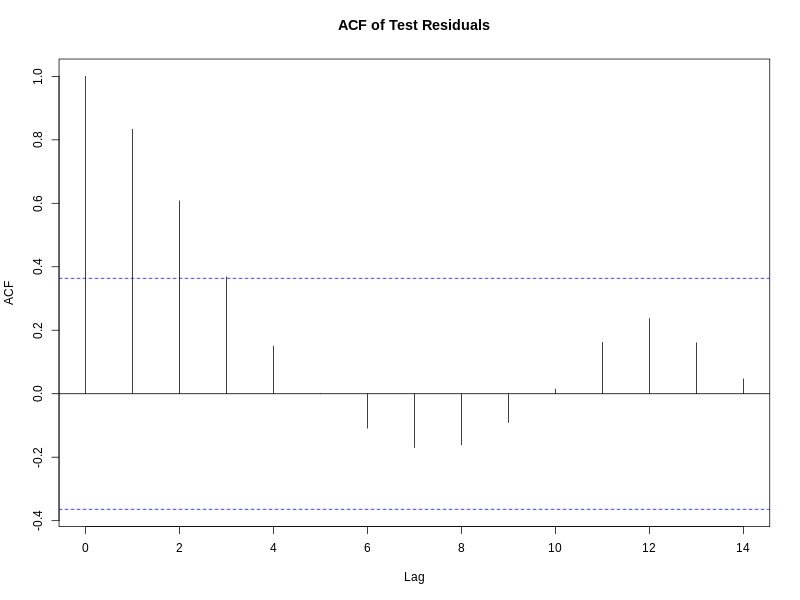

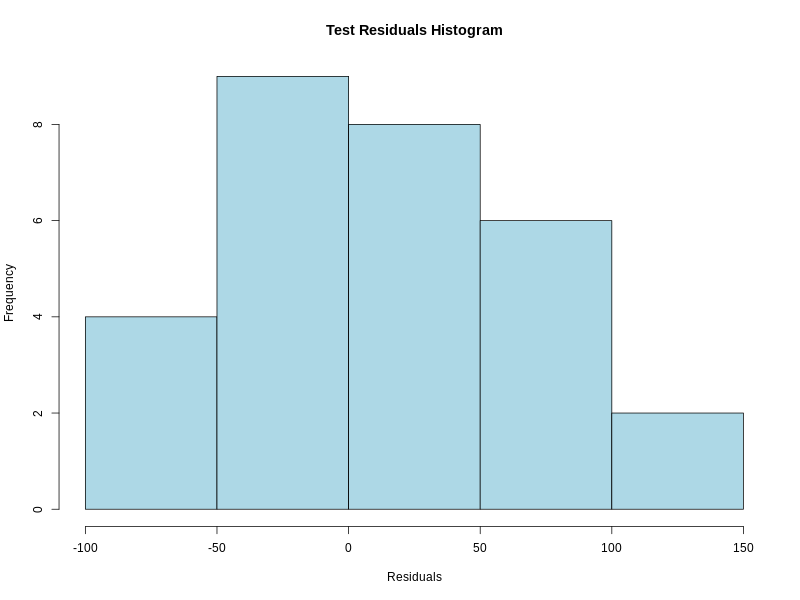

In [18]:
# R script for residuals diagnostics: ACF, histogram, Shapiro-Wilk normality test
r_code_residuals_diagnostics = """
# Load necessary libraries
library(ggplot2)

# Calculate test residuals
residuals_test <- y_test - predictions$mean

# Create the output directory if it doesn't exist
dir.create('/content/output_plots', showWarnings = FALSE)

# ACF plot
png('/content/output_plots/acf_residuals_test.png', width=800, height=600)
acf(residuals_test, main = "ACF of Test Residuals")
dev.off()

# Histogram plot
png('/content/output_plots/hist_residuals_test.png', width=800, height=600)
hist(residuals_test, main = "Test Residuals Histogram", col = "lightblue", xlab = "Residuals")
dev.off()

# Shapiro-Wilk test for normality
shapiro_test_result <- shapiro.test(residuals_test)

# Print the Shapiro-Wilk test result
cat("Shapiro-Wilk Test for Normality:\\n")
cat("W statistic: ", shapiro_test_result$statistic, "\\n")
cat("p-value: ", shapiro_test_result$p.value, "\\n")

# Return Shapiro-Wilk test results and success message
list(w_statistic = shapiro_test_result$statistic, p_value = shapiro_test_result$p.value, message = 'Residual diagnostics completed successfully')
"""

# Run the R script for residuals diagnostics
results_residuals_diagnostics = run_r_script(r_code_residuals_diagnostics)

# Extract the Shapiro-Wilk test results and success message
w_statistic = results_residuals_diagnostics[0]
p_value = results_residuals_diagnostics[1]
success_message = results_residuals_diagnostics[2]

# Print the Shapiro-Wilk test results and success message in Python
print(f"Shapiro-Wilk Test for Normality:\nW statistic: {w_statistic}\np-value: {p_value}")
print(success_message)

# Display the saved plots in the notebook
acf_residuals_test_plot = os.path.join(output_dir, "acf_residuals_test.png")
hist_residuals_test_plot = os.path.join(output_dir, "hist_residuals_test.png")

# Display the plots
display(Image(filename=acf_residuals_test_plot))
display(Image(filename=hist_residuals_test_plot))

# Model Comparison

Length of y_test: 29 
Number of rows in test_data: 29 
Length of y_test_aligned: 29 
Number of rows in test_data_aligned: 29 
Length of BSTS predictions$mean: 29 
Dimensions of BSTS predictions$interval: 2 29 
Length of lower_bound_bsts: 29 
Length of upper_bound_bsts: 29 
Saving plot to: /content/output_plots/bsts_vs_arima_comparison_with_legend.png 
Current working directory: /content 
Contents of output directory:
 [1] "acf_residuals_test.png"                  
 [2] "air_passengers_plot.png"                 
 [3] "bsts_acf_residuals.png"                  
 [4] "bsts_components.png"                     
 [5] "bsts_forecast_plot_with_legend.png"      
 [6] "bsts_in_sample_fit.png"                  
 [7] "bsts_prediction_errors.png"              
 [8] "bsts_residuals.png"                      
 [9] "bsts_vs_arima_comparison_with_legend.png"
[10] "hist_residuals_test.png"                 
[1] "BSTS vs. ARIMA comparison plot with legend created successfully"

Files in output directory: [

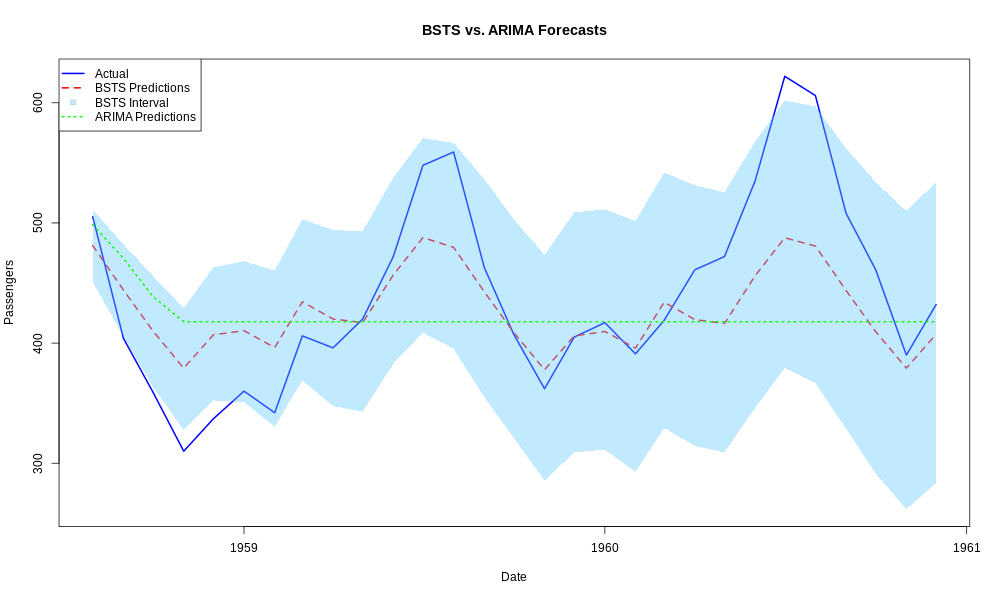

In [19]:
# R script for comparing BSTS vs. ARIMA model forecasts
r_code_arima_comparison = """
# Load necessary libraries
library(forecast)
library(ggplot2)

# Ensure y_test and test_data are aligned and have matching lengths
forecast_horizon <- length(y_test)
test_data_length <- nrow(test_data)

# Print lengths to debug
cat('Length of y_test:', forecast_horizon, '\\n')
cat('Number of rows in test_data:', test_data_length, '\\n')

# Adjust forecast_horizon if needed
forecast_horizon <- min(forecast_horizon, test_data_length)

# Truncate y_test and test_data to the forecast horizon length
y_test_aligned <- as.numeric(y_test[1:forecast_horizon])
test_data_aligned <- test_data[1:forecast_horizon, ]

# Ensure lengths match after alignment
cat('Length of y_test_aligned:', length(y_test_aligned), '\\n')
cat('Number of rows in test_data_aligned:', nrow(test_data_aligned), '\\n')

# Train a baseline ARIMA model on the training set
arima_model <- auto.arima(y_train)

# Forecast using ARIMA model
arima_forecast <- forecast(arima_model, h = forecast_horizon)

# Forecast (with intervals) for the test set horizon using BSTS
predictions_bsts <- predict(bsts_model, horizon = forecast_horizon)

# Print the structure and lengths of the BSTS prediction components
cat('Length of BSTS predictions$mean:', length(predictions_bsts$mean), '\\n')
cat('Dimensions of BSTS predictions$interval:', dim(predictions_bsts$interval), '\\n')

# Extraction of BSTS intervals
lower_bound_bsts <- as.numeric(predictions_bsts$interval[1, 1:forecast_horizon])  # First row (2.5%)
upper_bound_bsts <- as.numeric(predictions_bsts$interval[2, 1:forecast_horizon])  # Second row (97.5%)

# Check if the dimensions match
cat('Length of lower_bound_bsts:', length(lower_bound_bsts), '\\n')
cat('Length of upper_bound_bsts:', length(upper_bound_bsts), '\\n')

# Create comparison data frame with dates and forecasts from both models
comparison_df <- data.frame(
  date = as.Date(test_data_aligned$date),  # Use actual dates from the test set
  actual = y_test_aligned,
  predicted_bsts = predictions_bsts$mean[1:forecast_horizon],
  lower_bound_bsts = lower_bound_bsts,
  upper_bound_bsts = upper_bound_bsts,
  predicted_arima = arima_forecast$mean[1:forecast_horizon]
)

# Ensure the output directory exists
dir.create('/content/output_plots', showWarnings = FALSE)

# Save the plot as a PNG file and print file path
output_file <- '/content/output_plots/bsts_vs_arima_comparison_with_legend.png'
cat('Saving plot to:', output_file, '\\n')

# Adjust ylim to include the actual values, predictions, and intervals
y_range <- range(comparison_df$lower_bound_bsts, comparison_df$upper_bound_bsts,
                 comparison_df$predicted_arima, comparison_df$actual)

# Plot comparison of BSTS vs. ARIMA forecasts
png(output_file, width=1000, height=600)

# Base R plotting for comparison
plot(comparison_df$date, comparison_df$actual, type = "l", col = "blue", lwd = 2,
     ylim = y_range,  # Use the adjusted y_range
     xlab = "Date", ylab = "Passengers", main = "BSTS vs. ARIMA Forecasts")

lines(comparison_df$date, comparison_df$predicted_bsts, col = "red", lwd = 2, lty = 2)
polygon(c(comparison_df$date, rev(comparison_df$date)),
        c(comparison_df$lower_bound_bsts, rev(comparison_df$upper_bound_bsts)),
        col = rgb(0.4, 0.8, 1, alpha = 0.4), border = NA)  # Light blue with transparency for BSTS intervals
lines(comparison_df$date, comparison_df$predicted_arima, col = "green", lwd = 2, lty = 3)

# Add a legend to the plot
legend("topleft", legend = c("Actual", "BSTS Predictions", "BSTS Interval", "ARIMA Predictions"),
       col = c("blue", "red", "lightblue", "green"),
       lty = c(1, 2, NA, 3), lwd = c(2, 2, 1, 2), pt.bg = c(NA, NA, rgb(0.4, 0.8, 1, alpha = 0.4), NA),
       pch = c(NA, NA, 22, NA), bg = 'white')

dev.off()

# Print current working directory and contents for debugging
cat('Current working directory:', getwd(), '\\n')
cat('Contents of output directory:\\n')
print(list.files('/content/output_plots'))

# Return a success message
list(message = 'BSTS vs. ARIMA comparison plot with legend created successfully')
"""

# Run the R script for ARIMA comparison and plotting
results_arima_comparison = run_r_script(r_code_arima_comparison)

# Extract the success message
success_message = results_arima_comparison[0]

# Print the success message
print(success_message)

# Check the contents of the output directory
output_files = os.listdir(output_dir)
print("Files in output directory:", output_files)

# Display the saved ARIMA vs. BSTS comparison plot in the notebook if it exists
bsts_vs_arima_comparison_plot = os.path.join(output_dir, "bsts_vs_arima_comparison_with_legend.png")

if os.path.exists(bsts_vs_arima_comparison_plot):
    display(Image(filename=bsts_vs_arima_comparison_plot))
else:
    print("Plot file not found. Debug the output path and ensure the plot was saved correctly.")

# Save the Results

In [20]:
# R script to save forecast results and the model
r_code_save_forecast_and_model = """
# Save forecast results to a CSV
write.csv(forecast_df, "/content/output_plots/bsts_forecast_results.csv", row.names = FALSE)

# Save the BSTS model for future use
saveRDS(bsts_model, file = "/content/output_plots/bsts_model.rds")

# Print success message
cat("Forecast results saved to CSV and model saved as RDS.\\n")
list(message = "Forecast results and model saved successfully")
"""

# Run the R script to save forecast results and model
results_save_forecast_and_model = run_r_script(r_code_save_forecast_and_model)

# Extract the success message
success_message = results_save_forecast_and_model[0]

# Print the success message
print(success_message)

# Check the contents of the output directory to confirm files were saved
output_files = os.listdir(output_dir)
print("Files in output directory:", output_files)

# Verify that the files were saved
forecast_csv_file = os.path.join(output_dir, "bsts_forecast_results.csv")
bsts_model_file = os.path.join(output_dir, "bsts_model.rds")

if os.path.exists(forecast_csv_file):
    print(f"Forecast results CSV file saved successfully: {forecast_csv_file}")
else:
    print("Forecast CSV file not found. Debug if necessary.")

if os.path.exists(bsts_model_file):
    print(f"BSTS model RDS file saved successfully: {bsts_model_file}")
else:
    print("BSTS model RDS file not found. Debug if necessary.")

Forecast results saved to CSV and model saved as RDS.
[1] "Forecast results and model saved successfully"

Files in output directory: ['bsts_in_sample_fit.png', 'bsts_vs_arima_comparison_with_legend.png', 'bsts_model.rds', 'bsts_residuals.png', 'bsts_prediction_errors.png', 'bsts_forecast_plot_with_legend.png', 'bsts_forecast_results.csv', 'hist_residuals_test.png', 'acf_residuals_test.png', 'bsts_components.png', 'air_passengers_plot.png', 'bsts_acf_residuals.png']
Forecast results CSV file saved successfully: /content/output_plots/bsts_forecast_results.csv
BSTS model RDS file saved successfully: /content/output_plots/bsts_model.rds


Model loaded successfully from /content/output_plots/bsts_model.rds 
New predictions created successfully 
Length of new_predictions$mean: 29 
Saving plot to: /content/output_plots/bsts_new_forecast_plot_with_dates.png 
Plot saved successfully to: /content/output_plots/bsts_new_forecast_plot_with_dates.png 
Current working directory: /content 
Contents of output directory:
 [1] "acf_residuals_test.png"                  
 [2] "air_passengers_plot.png"                 
 [3] "bsts_acf_residuals.png"                  
 [4] "bsts_components.png"                     
 [5] "bsts_forecast_plot_with_legend.png"      
 [6] "bsts_forecast_results.csv"               
 [7] "bsts_in_sample_fit.png"                  
 [8] "bsts_model.rds"                          
 [9] "bsts_new_forecast_plot_with_dates.png"   
[10] "bsts_prediction_errors.png"              
[11] "bsts_residuals.png"                      
[12] "bsts_vs_arima_comparison_with_legend.png"
[13] "hist_residuals_test.png"                 


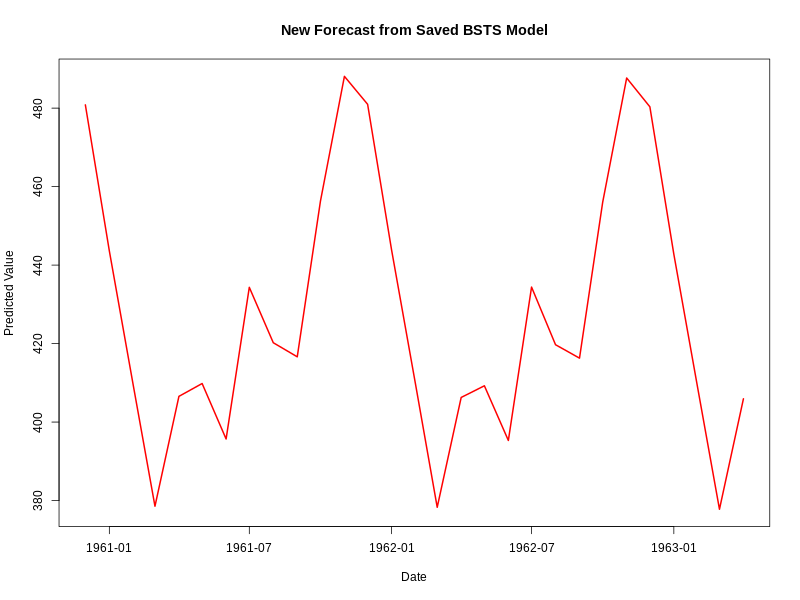

In [21]:
# R script to reload the model and plot a forecast
r_code_reload_and_forecast = """
# Reload the saved BSTS model from the RDS file
loaded_model <- readRDS("/content/output_plots/bsts_model.rds")

# Print confirmation of model loading
cat('Model loaded successfully from /content/output_plots/bsts_model.rds', '\\n')

# Make new predictions using the reloaded model
new_predictions <- predict(loaded_model, horizon = forecast_horizon)

# Print confirmation of predictions
cat('New predictions created successfully', '\\n')
cat('Length of new_predictions$mean:', length(new_predictions$mean), '\\n')

# Create a sequence of actual dates, using the last date from the test set to continue the timeline
start_date <- as.Date(test_data_aligned$date[nrow(test_data_aligned)])  # The last date from the test set
forecast_dates <- seq(start_date, by = "month", length.out = forecast_horizon)

# Create a data frame for plotting the new predictions with actual dates
new_forecast_df <- data.frame(
  date = forecast_dates,
  predicted = new_predictions$mean
)

# Ensure the output directory exists
dir.create('/content/output_plots', showWarnings = FALSE)

# Save the new forecast plot as a PNG file and print file path
output_file <- '/content/output_plots/bsts_new_forecast_plot_with_dates.png'
cat('Saving plot to:', output_file, '\\n')

# Plot using base R plotting with date axis
png(output_file, width=800, height=600)

plot(new_forecast_df$date, new_forecast_df$predicted, type = "l", col = "red", lwd = 2,
     xlab = "Date", ylab = "Predicted Value", main = "New Forecast from Saved BSTS Model")

dev.off()

# Print confirmation of plot creation
cat('Plot saved successfully to:', output_file, '\\n')

# Check the working directory
cat('Current working directory:', getwd(), '\\n')

# Print the contents of the output directory to debug
cat('Contents of output directory:\\n')
print(list.files('/content/output_plots'))

# Return a success message
list(message = 'New forecast from saved model with actual dates created successfully.')
"""

# Run the R script to reload the model and create a new forecast plot
results_reload_and_forecast = run_r_script(r_code_reload_and_forecast)

# Extract the success message
success_message = results_reload_and_forecast[0]

# Print the success message
print(success_message)

# Check the contents of the output directory to confirm the new forecast plot was saved
output_files = os.listdir(output_dir)
print("Files in output directory:", output_files)

# Display the saved new forecast plot in the notebook if it exists
bsts_new_forecast_plot_with_dates = os.path.join(output_dir, "bsts_new_forecast_plot_with_dates.png")

if os.path.exists(bsts_new_forecast_plot_with_dates):
    display(Image(filename=bsts_new_forecast_plot_with_dates))
else:
    print("New forecast plot file not found. Debug the output path and ensure the plot was saved correctly.")